Ibrahim Malik x23373385

# Data Analysis

## Library Imports

In [1]:
# handle warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# import relevant database manipulation libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType
from pyspark.sql.functions import col
from pyspark.sql import Row
from pyspark.sql.functions import expr
import psycopg2
from pymongo import MongoClient

In [3]:
# import required libraries for data handling and visualisations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go 
import plotly.express as px
import ipywidgets as widgets
from plotly.offline import init_notebook_mode, iplot

init_notebook_mode(connected=True)
%matplotlib inline
sns.set_palette('magma')

## Database SetUp

In [4]:
# initialize Spark session
spark = SparkSession.builder.appName("Analysis").config("spark.jars", "/home/ibrahimssmalik/Downloads/postgresql-42.6.0.jar").getOrCreate()

25/04/21 21:12:55 WARN Utils: Your hostname, scpserver-i resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/04/21 21:12:55 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
25/04/21 21:12:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### PostgreSQL Database

In [5]:
# import PostgresDBHelper to assist with database access and querying
from db_utils import PostgresDBHelper

In [6]:
# PostgreSQL Setup
pg_conn = psycopg2.connect(
    host="localhost",
    port=5432,
    dbname="disability_db",
    user="ibrahimssmalik",
    password="virtualbox2025"
)
pg_cursor = pg_conn.cursor()
print("Connected to PostgreSQL")

Connected to PostgreSQL


In [7]:
# set up sql database access
db_helper = PostgresDBHelper(spark, pg_conn)

In [8]:
# check for the tables present in database
db_helper.check_tables().show()

+----------------+
|      table_name|
+----------------+
|disability_stats|
|      categories|
|      indicators|
| stratifications|
|     income_data|
|     health_data|
|  education_data|
+----------------+



## Analysis

In [9]:
# investigate each table
tables_to_check = ['education_data', 'income_data', 'health_data', 'disability_stats']
for table in tables_to_check:
    print(f"\nSchema for {table}:")
    df = db_helper.run_query(f"SELECT * FROM {table} LIMIT 5;")
    df.printSchema()
    df.show()


Schema for education_data:
root
 |-- _id: string (nullable = true)
 |-- year: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- percent_bachelors_or_higher: string (nullable = true)

+--------------------+----+-----------+----------+---------------------------+
|                 _id|year|      state|state_code|percent_bachelors_or_higher|
+--------------------+----+-----------+----------+---------------------------+
|6806afcb37438555f...|2015|Mississippi|        28|                       82.3|
|6806afcb37438555f...|2015|   Missouri|        29|                       88.4|
|6806afcb37438555f...|2015|    Montana|        30|                       92.8|
|6806afcb37438555f...|2015|   Nebraska|        31|                       90.7|
|6806afcb37438555f...|2015|     Nevada|        32|                       85.1|
+--------------------+----+-----------+----------+---------------------------+


Schema for income_data:
root
 |-- Year: stri

25/04/21 21:13:18 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----+--------------------+-----------+-------------+-------+------+-------+--------+----------+--------+-----------+--------+-----------------+-------+-------+------+-----+--------+----+-------+------+--------+---------+-----+--------+-------------+--------+---------+-----------+--------+-------+--------+------+-------------+----------+----------+--------+--------------+------------+----+--------+------+------------+------------+--------------+------------+---------+-----+----+-------+--------+----------+-------------+---------+-------+
|Year|              Metric|Demographic|United States|Alabama|Alaska|Arizona|Arkansas|California|Colorado|Connecticut|Delaware|Dist. of Columbia|Florida|Georgia|Hawaii|Idaho|Illinois|Iowa|Indiana|Kansas|Kentucky|Louisiana|Maine|Maryland|Massachusetts|Michigan|Minnesota|Mississippi|Missouri|Montana|Nebraska|Nevada|New Hampshire|New Jersey|New Mexico|New York|North Carolina|North Dakota|Ohio|Oklahoma|Oregon|Pennsylvania|Rhode Island|South Carolina|South D

### Disability Prevalence by State

In [10]:
# disability prevalence by state
query = """
SELECT
    state,
    state_name,
    AVG(CASE WHEN strat_category1 = 'Disability Status' AND strat_value1 = 'Any Disability' THEN CAST(data_value AS FLOAT) ELSE NULL END) AS disability_prevalence
FROM disability_stats
GROUP BY state, state_name
ORDER BY disability_prevalence DESC;
"""
disability_prev = db_helper.run_pandas(query)
disability_prev['disability_prevalence'] = disability_prev['disability_prevalence'].astype(float)

In [11]:
disability_prev.head()

,state,state_name,disability_prevalence
0,VI,U.S. Virgin Islands,57.954850
1,GU,Guam,47.498204
2,WI,Wisconsin,45.834889
3,DC,District of Columbia,45.721837
4,RI,Rhode Island,45.678924


In [12]:
# visualise choropleth map for qualitative analysis
data = dict(
    type='choropleth', # initiate type of map
    locations=disability_prev['state'], # state abbreviations
    locationmode='USA-states', # type of map being used
    text=[disability_prev[['state_name', 'disability_prevalence']]], # tooltip text when hovering over state
    z=disability_prev['disability_prevalence'], # values for the color scale
    zmin=40, # minimum value of color scale
    zmax=50, # maximum value of color scale
    colorscale='magma_r', # type of color palette being used
    colorbar=dict(
        title='Prevalence Rate', # title
        # titleside='right', # alignment
        tickvals=[40, 45, 50], # tick values
        ticktext=['40', '45', '50'], # tick text labels
        tickfont=dict(size=12, color='black') # tick text font
    ),
    marker=dict(
        line=dict(color='rgb(255, 255, 255)', width=2) # white borders for states
    )
)

layout = dict(
    title=dict(
        text='Average US Disability Prevalence Rates (2016-2022)', # title of plot
        font=dict(size=20, color='black', family='Arial Black'), # title specifications
        x=0.5, # title centered
        xanchor='center', # horizontal alignment
        y=0.95, # title vertical position
        yanchor='top' # vertical alignment
    ),
    geo=dict(
        scope='usa', # show map of usa
        showframe=True, # show map frame
        projection=dict(
            type='albers usa' # albers projection for better map visualization
        ),
        subunitcolor='rgb(255, 255, 255)', # white state borders
        subunitwidth=1 # state border width
    ),
    width=800, # width for map
    height=600, # height for map
    margin=dict(l=0,r=0,t=40,b=0), # left, right, top, bottom margins
)

choromap = go.Figure(data=[data], layout=layout) # create figure
iplot(choromap, validate=False) # plotting map

### Education and Disability Prevalence

In [13]:
# relationship between education and disability
query = """
SELECT 
    d.year, 
    d.state, 
    d.state_name, 
    CAST(e.percent_bachelors_or_higher AS FLOAT) AS education_rate, 
    ROUND(CAST(AVG(CASE 
                   WHEN d.strat_category1 = 'Disability Status' 
                    AND d.strat_value1 = 'Any Disability' 
                   THEN CAST(d.data_value AS FLOAT) 
                   ELSE NULL END) AS NUMERIC), 2) AS disability_prevalence 
FROM disability_stats d 
JOIN education_data e 
  ON d.state_name = e.state AND d.year = e.year 
GROUP BY d.year, d.state, d.state_name, e.percent_bachelors_or_higher 
ORDER BY disability_prevalence DESC;
"""
disability_edu = db_helper.run_pandas(query)

In [14]:
# convert numeric data into float dtype
disability_edu['education_rate'] = disability_edu['education_rate'].astype(float)
disability_edu['disability_prevalence'] = disability_edu['disability_prevalence'].astype(float)

In [15]:
disability_edu.head()

,year,state,state_name,education_rate,disability_prevalence
0,2021,WI,Wisconsin,92.9,47.64
1,2021,DC,District of Columbia,92.2,47.43
2,2021,IL,Illinois,89.9,47.42
3,2021,RI,Rhode Island,89.1,46.72
4,2021,NV,Nevada,87.0,46.70


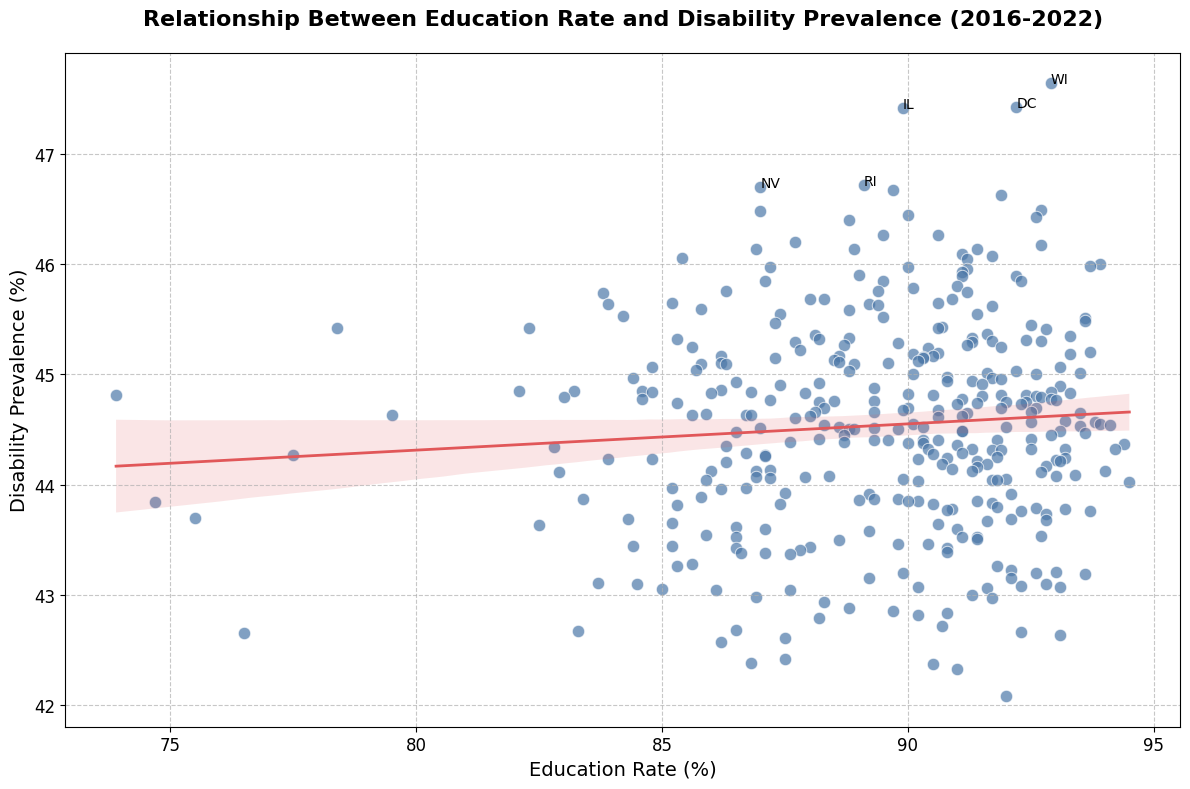

In [16]:
# scatter plot
plt.figure(figsize=(12, 8))  # Larger figure size for better visibility

# create scatter plot
sns.scatterplot(
    data=disability_edu, 
    x='education_rate', 
    y='disability_prevalence', 
    alpha=0.7, # keep transparency
    s=80, # larger point size
    color='#4c78a8'
)

# add trend line to highlight relationship
sns.regplot(
    data=disability_edu,
    x='education_rate', 
    y='disability_prevalence',
    scatter=False, # don't add more scatter points
    color='#e15759',
    line_kws={'linewidth': 2}
)

# labels and title
plt.title('Relationship Between Education Rate and Disability Prevalence (2016-2022)', fontweight='bold', fontsize=16, pad=20)
plt.xlabel('Education Rate (%)', fontsize=14)
plt.ylabel('Disability Prevalence (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# add grid lines for readability
plt.grid(True, linestyle='--', alpha=0.7)

# improve overall layout
plt.tight_layout()

# annotate points
threshold = disability_edu['disability_prevalence'].max()*0.98
for i, row in disability_edu.iterrows():
    if row['disability_prevalence'] > threshold: # annotate notable points
        plt.annotate(row['state'], (row['education_rate'], row['disability_prevalence']))

# plt.savefig('education_disability.png', dpi=300, bbox_inches='tight')

plt.show()

In [17]:
correlation = disability_edu['education_rate'].corr(disability_edu['disability_prevalence'])
print(f"Pearson's Correlation Coefficient: {correlation:.4f}")

Pearson's Correlation Coefficient: 0.0815


### Health and Disability Prevalence

In [18]:
# relationship between health and disability
query = """
SELECT 
    *
FROM health_data
WHERE "Metric" LIKE '%Adults Reporting Not Having a Personal Doctor%' 
  AND "Metric" NOT LIKE '%by Race/Ethnicity%';
"""
health_wide = db_helper.run_pandas(query)

In [19]:
# ensure that the non-state fields are lower case for scalability and efficiency
for enum,col in enumerate(health_wide.columns):
    if enum < 3:
        health_wide.rename(columns={health_wide.columns[enum]:col.lower()},inplace=True)

In [20]:
# convert health data into long format
health_long = pd.melt(
    health_wide,
    id_vars=['year', 'metric', 'demographic'],
    var_name='state',
    value_name='percentage'
)

In [21]:
health_long.head()

,year,metric,demographic,state,percentage
0,2015,"Adults Reporting Not Having a Personal Doctor,...",Male,United States,27.1
1,2015,"Adults Reporting Not Having a Personal Doctor,...",Female,United States,16.2
2,2016,"Adults Reporting Not Having a Personal Doctor,...",Male,United States,27.5
3,2016,"Adults Reporting Not Having a Personal Doctor,...",Female,United States,16.7
4,2017,"Adults Reporting Not Having a Personal Doctor,...",Male,United States,28.2


In [22]:
# convert numeric data into float dtype
health_long = health_long[~health_long['percentage'].isnull()][['year','state','demographic','percentage']]
health_long['percentage'] = health_long['percentage'].astype(float)
health_long = health_long.groupby(['year','state']).agg({'percentage':'mean'}).reset_index()
health_long.rename(columns={'percentage':'% Adults with No Doctor'},inplace=True)

In [23]:
health_long.head()

,year,state,% Adults with No Doctor
0,2015,Alabama,21.10
1,2015,Alaska,34.90
2,2015,Arizona,27.60
3,2015,Arkansas,16.60
4,2015,California,23.45


In [24]:
# relationship between health and disability
query = """
SELECT
    year,
    state,
    state_name,
    AVG(CASE WHEN strat_category1 = 'Disability Status' AND strat_value1 = 'Any Disability' THEN CAST(data_value AS FLOAT) ELSE NULL END) AS disability_prevalence
FROM disability_stats
GROUP BY state, state_name, year
ORDER BY disability_prevalence DESC;
"""
disability_state = db_helper.run_pandas(query)
disability_state['disability_prevalence'] = disability_state['disability_prevalence'].astype(float)

In [25]:
disability_state.head()

,year,state,state_name,disability_prevalence
0,2021,VI,U.S. Virgin Islands,61.451331
1,2022,VI,U.S. Virgin Islands,60.615753
2,2016,VI,U.S. Virgin Islands,51.895714
3,2021,GU,Guam,50.189458
4,2022,GU,Guam,50.066313


In [26]:
# merge DataFrames on "Year"
disability_health = pd.merge(
    health_long, 
    disability_state, 
    left_on=["year","state"], 
    right_on=["year","state_name"], 
    how="inner"  # Change to 'left', 'right', or 'outer' depending on your use case
)
disability_health = disability_health[['year','state_x','state_name','% Adults with No Doctor','disability_prevalence']].rename(columns={'state_x':'state'})

In [27]:
disability_health.head()

,year,state,state_name,% Adults with No Doctor,disability_prevalence
0,2016,Alabama,Alabama,21.55,44.228881
1,2016,Alaska,Alaska,31.70,45.853493
2,2016,Arizona,Arizona,26.80,45.103833
3,2016,Arkansas,Arkansas,19.75,45.647348
4,2016,California,California,24.10,44.853808


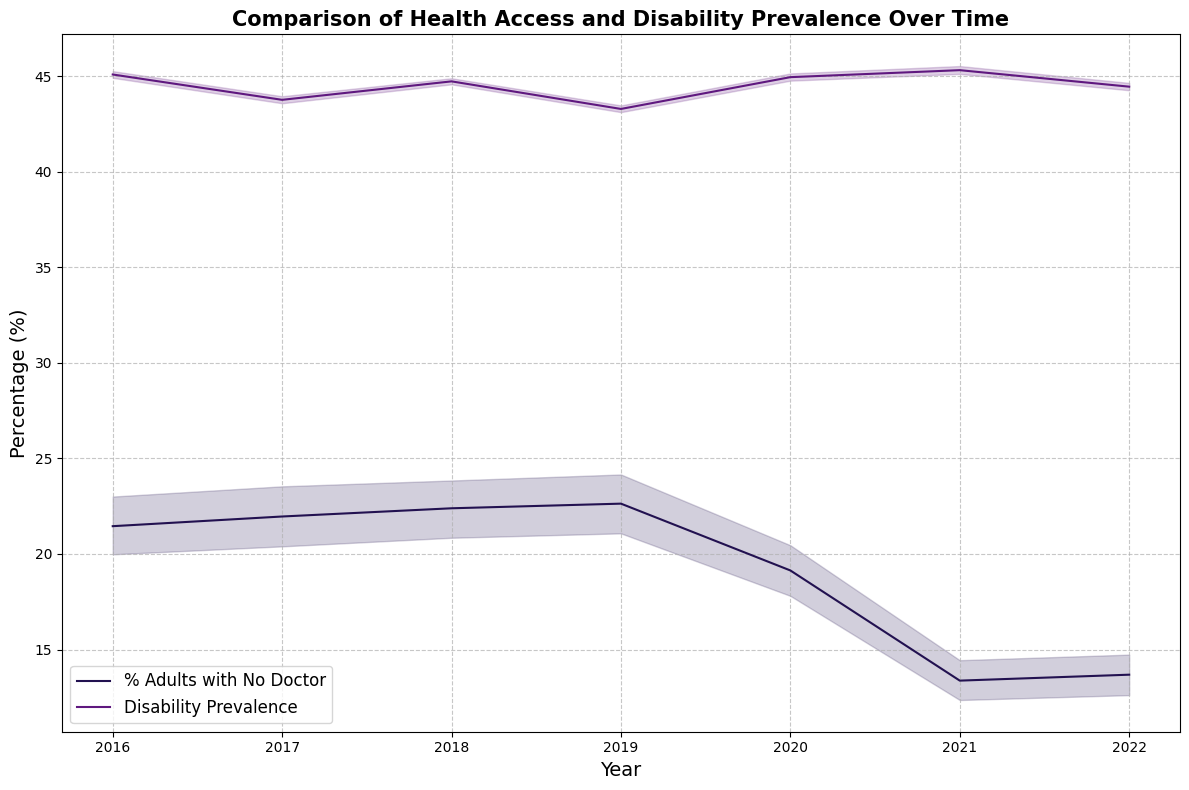

In [28]:
# choose fields for visualisation
dis_health_comparison = disability_health[['year','% Adults with No Doctor','disability_prevalence']]

plt.figure(figsize=(12, 8))

# plot each line
sns.lineplot(data=dis_health_comparison, x='year', y='% Adults with No Doctor', label='% Adults with No Doctor')
sns.lineplot(data=dis_health_comparison, x='year', y='disability_prevalence', label='Disability Prevalence')

# add title and labels
plt.title('Comparison of Health Access and Disability Prevalence Over Time', fontweight='bold', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Percentage (%)', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()

# plt.savefig('health_vs_disability.png', dpi=300, bbox_inches='tight')

plt.show()

In [29]:
correlation = dis_health_comparison['% Adults with No Doctor'].corr(dis_health_comparison['disability_prevalence'])
print(f"Pearson's Correlation Coefficient: {correlation:.4f}")

Pearson's Correlation Coefficient: -0.2575


In [30]:
correlation_by_year = dis_health_comparison.groupby('year').apply(
    lambda x: x['% Adults with No Doctor'].corr(x['disability_prevalence'])
)
# highlight significant correlations
significant_years = correlation_by_year[abs(correlation_by_year) > 0.1]
print("Significant years:", significant_years)

Significant years: year
2017   -0.155865
2018   -0.142571
2020   -0.111389
2021   -0.133059
dtype: float64


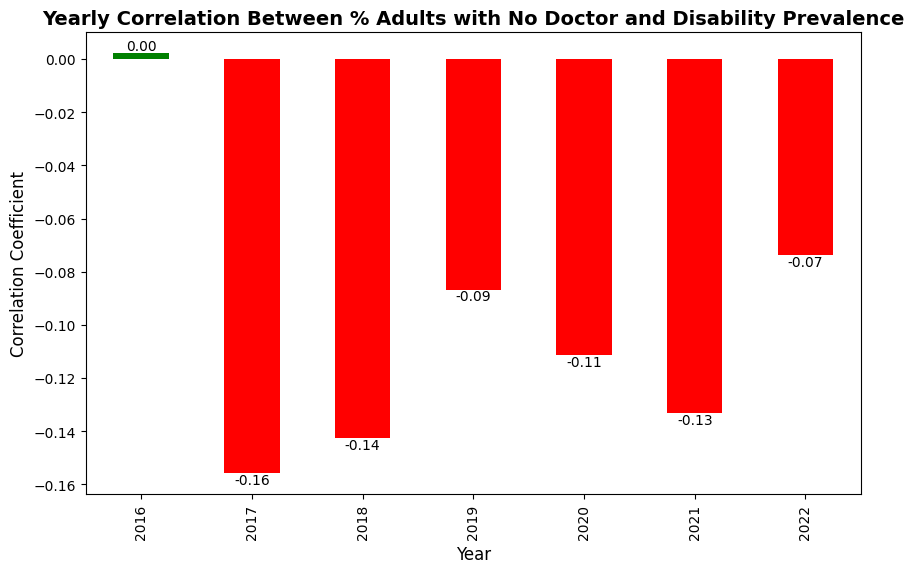

In [31]:
# visualise correlation by year
correlation_by_year.plot(kind='bar', color=['green' if c > 0 else 'red' for c in correlation_by_year], figsize=(10, 6))
plt.title('Yearly Correlation Between % Adults with No Doctor and Disability Prevalence', fontweight='bold', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Correlation Coefficient', fontsize=12)

# annotate bars
for idx, value in enumerate(correlation_by_year):
    plt.text(idx, value, f'{value:.2f}', ha='center', va='bottom' if value > 0 else 'top', fontsize=10)

# plt.savefig('health_vs_disability_corr.png', dpi=300, bbox_inches='tight')

plt.show()

### Income and Disability Prevalence

In [32]:
# relationship between income and disability
query = """
WITH region_income AS (
    SELECT
        "Year",
        "Characteristic",
        "Population_Thousands",
        "Median_Income"
    FROM income_data
    WHERE "Stratification" = 'Region'
)
SELECT
    d."year",
    AVG(CASE 
        WHEN d."strat_category1" = 'Disability Status' 
         AND d."strat_value1" = 'Any Disability' 
        THEN CAST(d."data_value" AS FLOAT) 
        ELSE NULL 
    END) AS disability_prevalence,
    AVG(r."Median_Income") AS avg_median_income
FROM disability_stats d
JOIN region_income r ON r."Year" = d."year"
GROUP BY d."year";
"""
disability_income = db_helper.run_pandas(query)

In [33]:
# convert numeric data into float dtype
disability_income['disability_prevalence'] = disability_income['disability_prevalence'].astype(float)
disability_income['avg_median_income'] = disability_income['avg_median_income'].astype(float)

In [34]:
disability_income.head()

,year,disability_prevalence,avg_median_income
0,2016,44.930879,61502.25
1,2017,43.542361,62703.00
2,2018,44.511750,66432.25
3,2019,43.071835,70557.00
4,2020,44.708857,73167.50


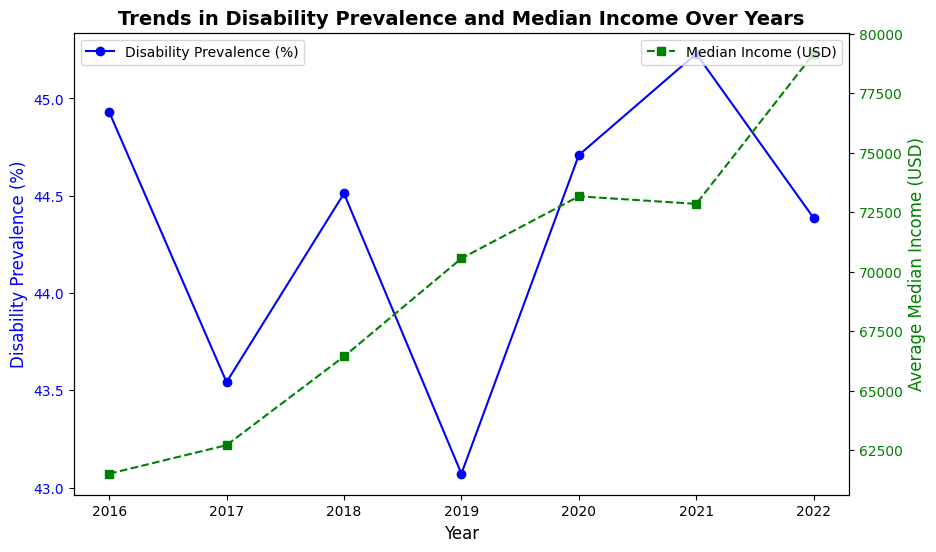

In [35]:
# creating figure and axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# plotting disability prevalence (line plot)
ax1.plot(disability_income['year'], disability_income['disability_prevalence'], color='blue', marker='o', label='Disability Prevalence (%)')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Disability Prevalence (%)', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# adding the second Y-Axis for median income
ax2 = ax1.twinx()
ax2.plot(disability_income['year'], disability_income['avg_median_income'], color='green', marker='s', linestyle='--', label='Median Income (USD)')
ax2.set_ylabel('Average Median Income (USD)', color='green', fontsize=12)
ax2.tick_params(axis='y', labelcolor='green')

plt.title('Trends in Disability Prevalence and Median Income Over Years', fontweight='bold', fontsize=14)
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.grid(axis='x', linestyle='--', alpha=0.6)

# plt.savefig('income_vs_disability.png', dpi=300, bbox_inches='tight')

plt.show()

In [36]:
correlation = disability_income['avg_median_income'].corr(disability_income['disability_prevalence'])
print(f"Pearson's Correlation Coefficient: {correlation:.4f}")

Pearson's Correlation Coefficient: 0.1235


### Multi-Modal Analysis

In [37]:
health_income_prev = pd.merge(
    disability_health, 
    disability_income, 
    left_on=["year"], 
    right_on=["year"], 
    how="inner"
).drop(columns=['disability_prevalence_x']).rename(columns={'disability_prevalence_y':'disability_prevalence'})

In [38]:
health_income_edu_prev = pd.merge(
    health_income_prev, 
    disability_edu, 
    left_on=["year","state_name"], 
    right_on=["year","state_name"], 
    how="inner"
).drop(columns=['disability_prevalence_x','state_y']).rename(columns={'disability_prevalence_y':'disability_prevalence','state_x':'state'})

In [39]:
health_income_edu_prev.head()

,year,state,state_name,% Adults with No Doctor,avg_median_income,education_rate,disability_prevalence
0,2016,Alabama,Alabama,21.55,61502.25,84.8,44.23
1,2016,Alaska,Alaska,31.70,61502.25,92.3,45.85
2,2016,Arizona,Arizona,26.80,61502.25,86.2,45.10
3,2016,Arkansas,Arkansas,19.75,61502.25,85.2,45.65
4,2016,California,California,24.10,61502.25,82.1,44.85


In [40]:
# health_income_edu_prev.to_csv('disability_data_complete.csv')

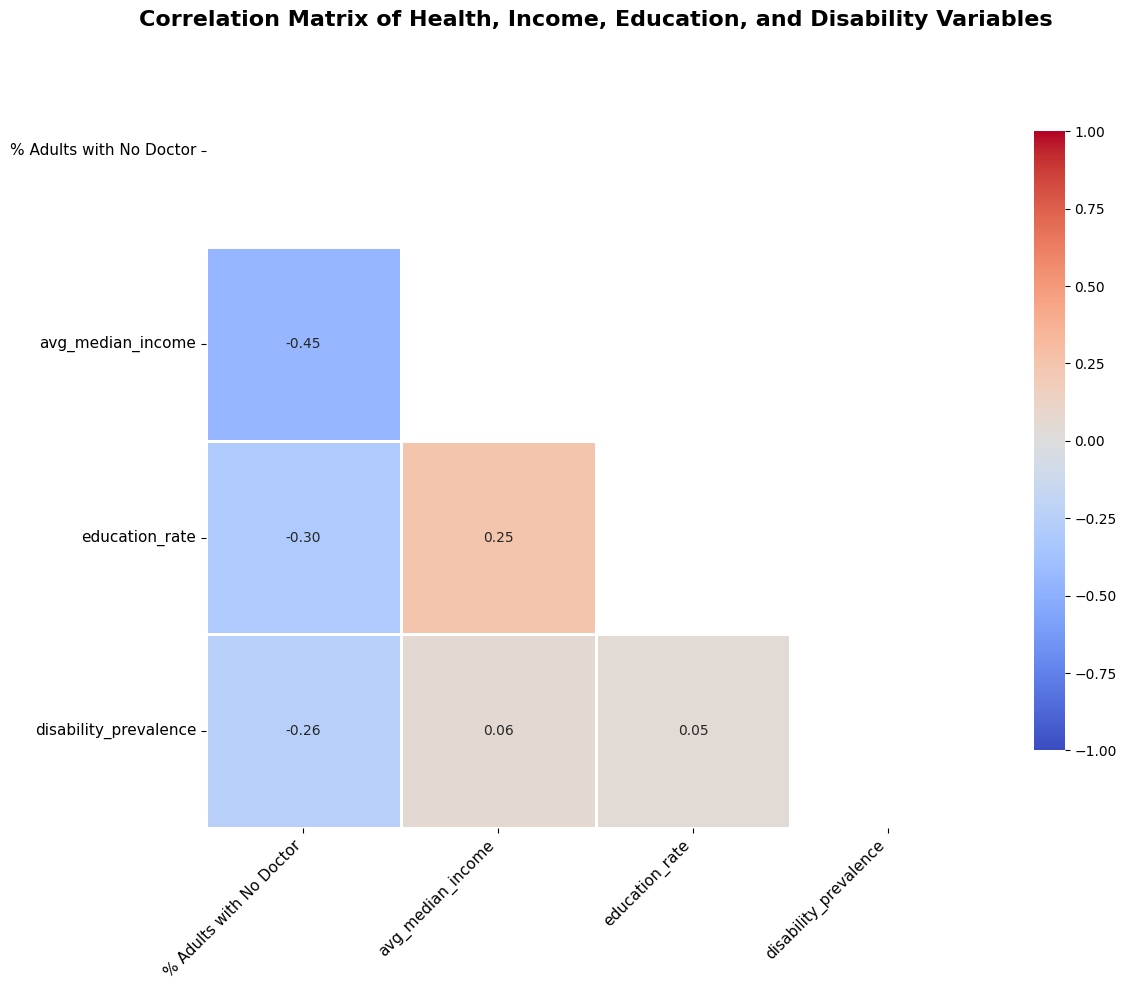

In [41]:
# create enhanced correlation matrix
plt.figure(figsize=(12, 10))

# generate correlation matrix
correlation_matrix = health_income_edu_prev.select_dtypes(include='number').corr()

# create mask for upper triangle to avoid redundancy
mask = np.triu(correlation_matrix)

# create heatmap
sns.heatmap(correlation_matrix,
    annot=True, fmt='.2f', cmap='coolwarm',
    linewidths=1, linecolor='white', mask=mask,
    annot_kws={"size": 10}, vmin=-1, vmax=1, cbar_kws={"shrink": .8}
)

plt.title('Correlation Matrix of Health, Income, Education, and Disability Variables', fontweight='bold', fontsize=16, pad=20)

# rotate axis labels
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(rotation=0, fontsize=11)

plt.tight_layout()

# plt.savefig('main_corr.png', dpi=300, bbox_inches='tight')

plt.show()

### Machine Learning

In [42]:
# disability Prevalence Prediction using Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance

In [43]:
# select features and target
X = health_income_edu_prev[['% Adults with No Doctor', 'avg_median_income', 'education_rate']]
y = health_income_edu_prev['disability_prevalence']

In [44]:
# split data into testing and training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# initialize relevant regression models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

In [47]:
# store models
models = {
    "Linear Regression": lr_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gb_model
}

In [48]:
# train and evaluate models
results = {}

for name, model in models.items():
    # Train
    model.fit(X_train_scaled, y_train)
    
    # Predict
    y_pred = model.predict(X_test_scaled)
    
    # Evaluate
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    
    results[name] = {
        'model': model,
        'mse': mse,
        'r2': r2,
        'cv_r2_mean': cv_scores.mean(),
        'cv_r2_std': cv_scores.std()
    }

In [49]:
# show results
for name, metrics in results.items():
    print(f"\n{name} Results:")
    print(f"MSE: {metrics['mse']:.4f}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"5-Fold CV R² Score: {metrics['cv_r2_mean']:.4f} ± {metrics['cv_r2_std']:.4f}")


Linear Regression Results:
MSE: 0.8310
R² Score: 0.0974
5-Fold CV R² Score: 0.0336 ± 0.0458

Random Forest Results:
MSE: 0.5819
R² Score: 0.3679
5-Fold CV R² Score: 0.3265 ± 0.0893

Gradient Boosting Results:
MSE: 0.4698
R² Score: 0.4897
5-Fold CV R² Score: 0.3858 ± 0.0752


In [50]:
# choose best model (based on R²)
best_model_name = max(results, key=lambda x: results[x]['r2'])
best_model = results[best_model_name]['model']
print(f"\nBest Model: {best_model_name}")


Best Model: Gradient Boosting


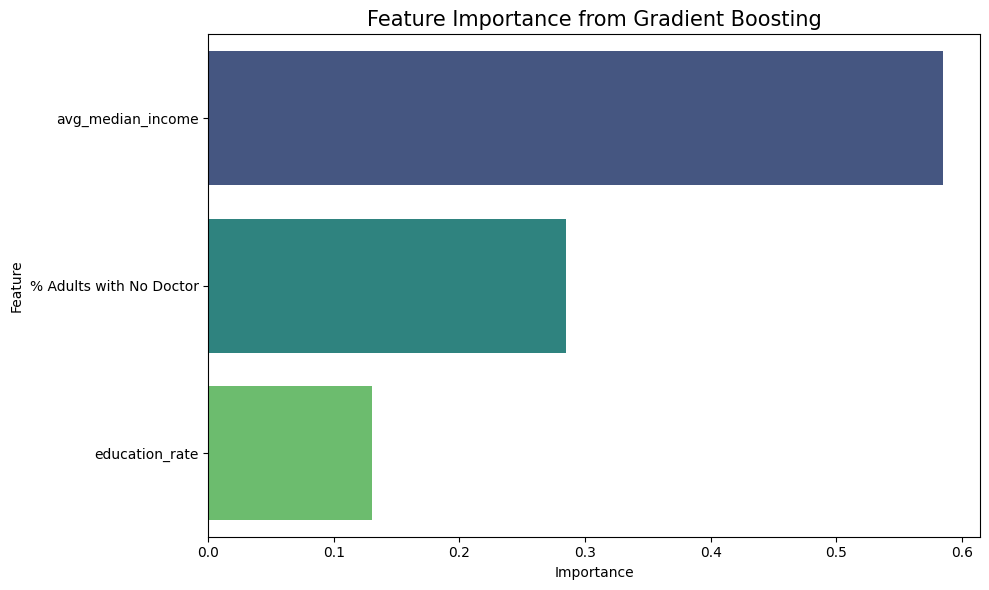

In [51]:
# feature importance for best model
if best_model_name != "Linear Regression":
    importances = best_model.feature_importances_
    feature_names = X.columns
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
    plt.title(f'Feature Importance from {best_model_name}', fontsize=15)
    plt.tight_layout()
    # plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    coeffs = best_model.coef_
    feature_names = X.columns
    
    # Create coefficient DataFrame
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': coeffs
    }).sort_values('Coefficient', ascending=False)
    
    # Plot coefficients
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Coefficient', y='Feature', data=coef_df, palette='viridis')
    plt.title('Feature Coefficients from Linear Regression', fontweight='bold', fontsize=15)
    plt.tight_layout()
    # plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()

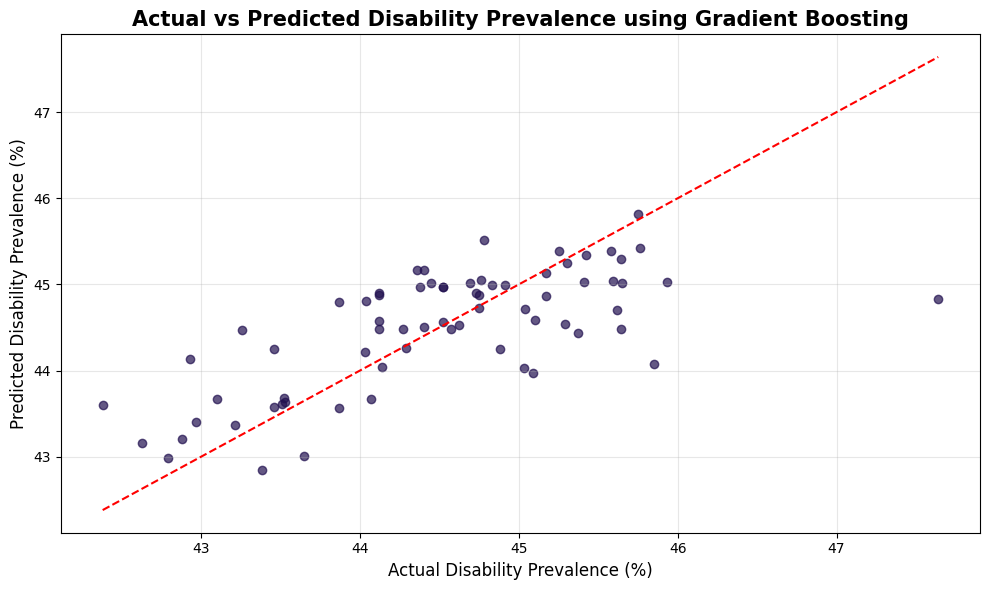

In [52]:
# visualize predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, best_model.predict(X_test_scaled), alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Disability Prevalence (%)', fontsize=12)
plt.ylabel('Predicted Disability Prevalence (%)', fontsize=12)
plt.title(f'Actual vs Predicted Disability Prevalence using {best_model_name}', fontweight='bold', fontsize=15)
plt.grid(True, alpha=0.3)
plt.tight_layout()
# plt.savefig('act_vs_pred.png', dpi=300, bbox_inches='tight')
plt.show()

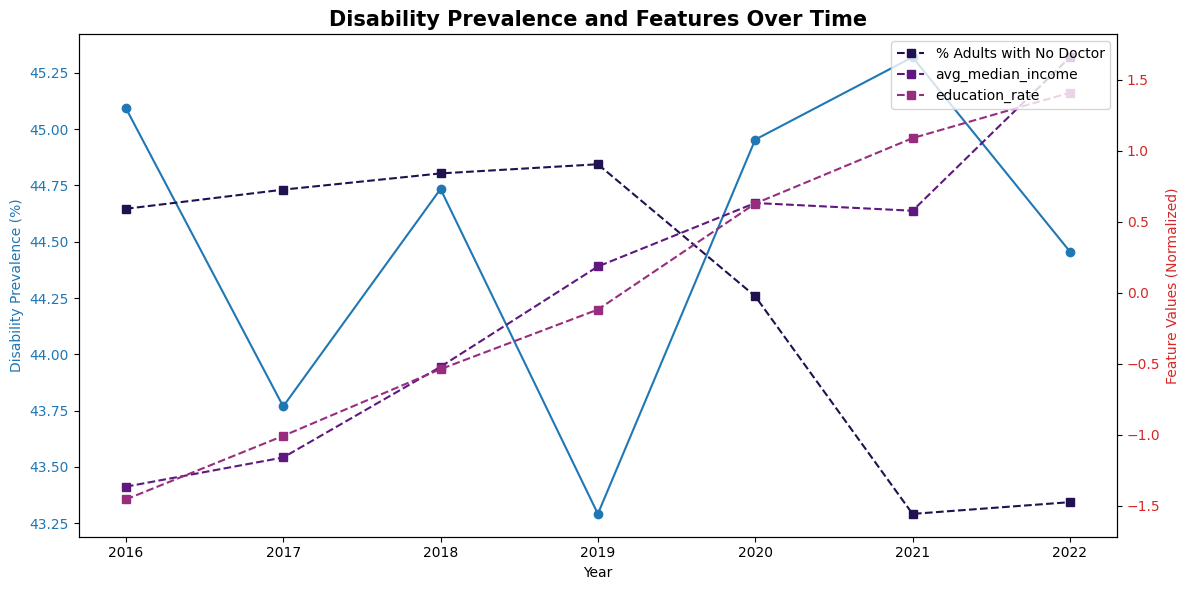

In [53]:
# time series analysis
if len(health_income_edu_prev['year'].unique()) > 1:
    yearly_data = health_income_edu_prev.groupby('year').agg({
        '% Adults with No Doctor': 'mean',
        'avg_median_income': 'mean',
        'education_rate': 'mean',
        'disability_prevalence': 'mean'
    }).reset_index()
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot disability prevalence
    color = 'tab:blue'
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Disability Prevalence (%)', color=color)
    ax1.plot(yearly_data['year'], yearly_data['disability_prevalence'], 'o-', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Create a second y-axis for the other features
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Feature Values (Normalized)', color=color)
    
    # Normalize other features for better comparison
    scaler = StandardScaler()
    features = ['% Adults with No Doctor', 'avg_median_income', 'education_rate']
    normalized = scaler.fit_transform(yearly_data[features])
    
    for i, feature in enumerate(features):
        ax2.plot(yearly_data['year'], normalized[:, i], 's--', label=feature)
    
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='upper right')
    
    plt.title('Disability Prevalence and Features Over Time', fontweight='bold', fontsize=15)
    plt.tight_layout()
    # plt.savefig('features_time.png', dpi=300, bbox_inches='tight')
    plt.show()

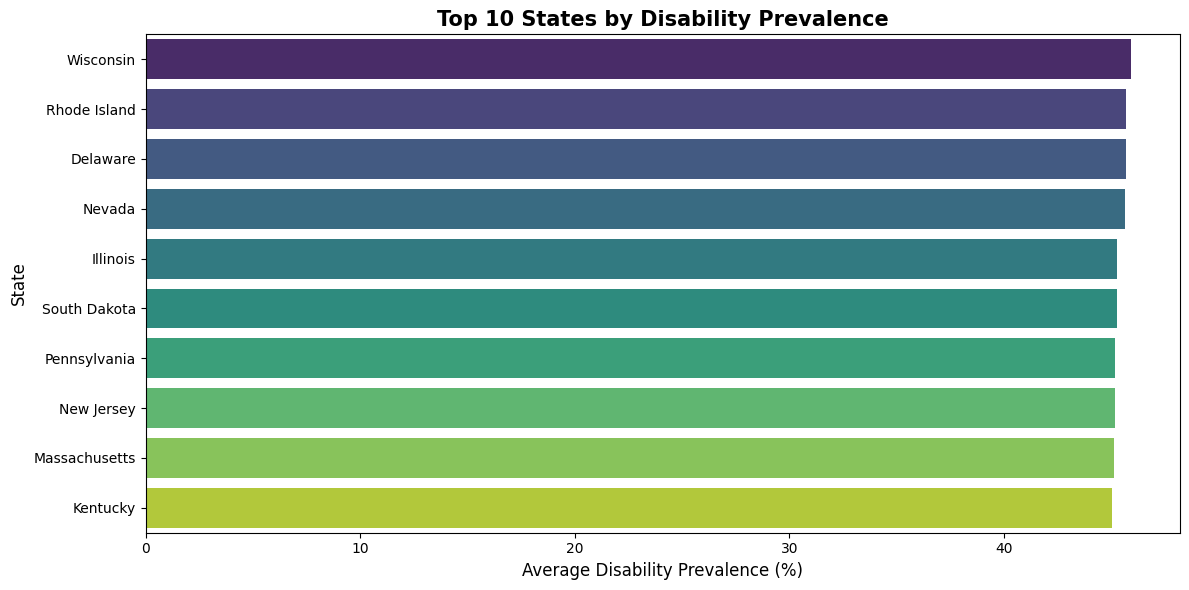

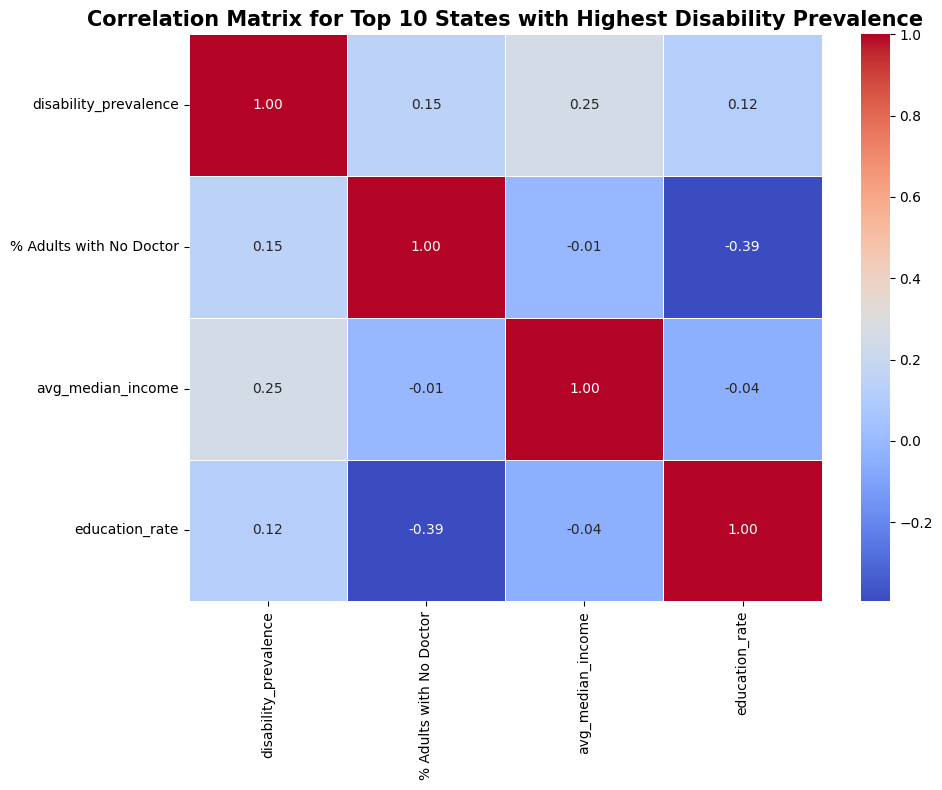

In [54]:
# State-by-state analysis
if 'state' in health_income_edu_prev.columns:
    # Get average disability prevalence by state
    state_avg = health_income_edu_prev.groupby('state_name').agg({
        'disability_prevalence': 'mean',
        '% Adults with No Doctor': 'mean',
        'avg_median_income': 'mean',
        'education_rate': 'mean'
    }).reset_index()
    
    # Top 10 states with highest disability prevalence
    top_states = state_avg.sort_values('disability_prevalence', ascending=False).head(10)
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='disability_prevalence', y='state_name', data=top_states, palette='viridis')
    plt.title('Top 10 States by Disability Prevalence', fontweight='bold', fontsize=15)
    plt.xlabel('Average Disability Prevalence (%)', fontsize=12)
    plt.ylabel('State', fontsize=12)
    plt.tight_layout()
    # plt.savefig('top_10_states_bar.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create correlation heatmap for top states
    corr_metrics = ['disability_prevalence', '% Adults with No Doctor', 'avg_median_income', 'education_rate']
    plt.figure(figsize=(10, 8))
    sns.heatmap(top_states[corr_metrics].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Matrix for Top 10 States with Highest Disability Prevalence', fontweight='bold', fontsize=15)
    plt.tight_layout()
    # plt.savefig('top_10_states_corr.png', dpi=300, bbox_inches='tight')
    plt.show()